<a href="https://colab.research.google.com/github/dominikwernerwolf/coursera/blob/main/Validation_regularisation_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [3]:
# Save the input and target variables

print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [4]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0))/targets.std()

In [5]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(train_data):
    model = Sequential([
      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(1)
    ])
    return model

model = get_model(train_data)

In [7]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [8]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [9]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 1.4854 - mae: 0.9345 - 17ms/epoch - 9ms/step


[1.4854146242141724, 0.9345197081565857]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

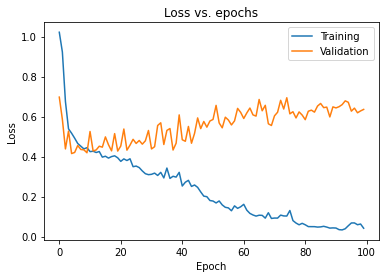

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1E-5, 0.3)

In [16]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 0.8707 - mae: 0.7166 - 15ms/epoch - 8ms/step


[0.8707431554794312, 0.7166360020637512]

#### Plot the learning curves

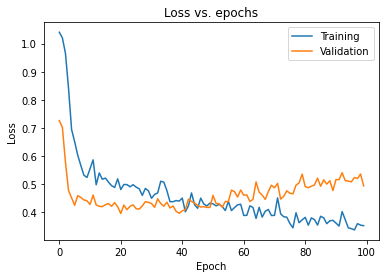

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

  def on_train_begin(self, logs=None):
    print("Training initialised!")

  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch (epoch)")

  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch (batch)")

  def on_train_batch_end(self, batch, logs=None):
    print(f"Training: Finished batch (batch)")

  def on_epoch_end(self, epoch, logs=None):
    print(f"Finished epoch (batch)")

  def on_train_end(self, logs=None):
    print("Training completed!")


class TestingCallback(Callback):

  def on_test_begin(self, logs=None):
    print("Testing initialised!")

  def on_test_batch_begin(self, batch, logs=None):
    print(f"Testing: Starting batch (batch)")

  def on_test_batch_end(self, batch, logs=None):
    print(f"Testing: Finished batch (batch)")

  def on_test_end(self, logs=None):
    print("Testing completed!")


class PredictionCallback(Callback):

  def on_predict_begin(self, logs=None):
    print("Prediction initialised!")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f"Prediction: Starting batch (batch)")

  def on_predict_batch_end(self, batch, logs=None):
    print(f"Prediction: Finished batch (batch)")

  def on_predict_end(self, logs=None):
    print("Prediction completed!")


In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_target, epochs=3, batch_size=120, verbose=2, callbacks=[TrainingCallback()])

Training initialised!
Starting epoch (epoch)
Epoch 1/3
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Finished epoch (batch)
4/4 - 1s - loss: 0.9944 - 882ms/epoch - 221ms/step
Starting epoch (epoch)
Epoch 2/3
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Finished epoch (batch)
4/4 - 0s - loss: 0.9840 - 29ms/epoch - 7ms/step
Starting epoch (epoch)
Epoch 3/3
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training

In [24]:
# Evaluate the model

model.evaluate(test_data, test_target, verbose=False, callbacks=[TestingCallback()])

Testing initialised!
Testing: Starting batch (batch)
Testing: Finished batch (batch)
Testing: Starting batch (batch)
Testing: Finished batch (batch)
Testing completed!


1.076389193534851

In [25]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Prediction initialised!
Prediction: Starting batch (batch)
Prediction: Finished batch (batch)
Prediction: Starting batch (batch)
Prediction: Finished batch (batch)
Prediction completed!


array([[ 0.04892818],
       [-0.00110768],
       [-0.00195843],
       [-0.02008077],
       [ 0.01095616],
       [-0.00409248],
       [-0.0067094 ],
       [ 0.04173809],
       [ 0.07692924],
       [ 0.02517956],
       [ 0.06174462],
       [ 0.03131869],
       [-0.01993974],
       [-0.01979409],
       [ 0.018322  ],
       [ 0.08052234],
       [ 0.06971043],
       [ 0.06612371],
       [ 0.04072603],
       [ 0.0929784 ],
       [ 0.02089716],
       [ 0.06731771],
       [ 0.02274294],
       [ 0.1055041 ],
       [ 0.15256163],
       [ 0.04916902],
       [ 0.0570517 ],
       [ 0.09437625],
       [ 0.10185178],
       [ 0.01460914],
       [ 0.01140788],
       [ 0.0415195 ],
       [ 0.09546951],
       [ 0.03699153],
       [ 0.03432007],
       [ 0.08586342],
       [-0.00606172],
       [-0.00683823],
       [-0.01717251],
       [ 0.03412352],
       [ 0.02457254],
       [ 0.11938723],
       [ 0.0863954 ],
       [ 0.12503542],
       [ 0.1420163 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [33]:
# Re-train the unregularised model

unregularized_model = get_model(train_data)
unregularized_model.compile(optimizer='adam', loss='mae')
unreg_history = unregularized_model.fit(train_data, train_target, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [34]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 0.6837 - 16ms/epoch - 8ms/step


0.6836777329444885

In [35]:
# Re-train the regularised model

regularized_model = get_regularised_model(1E-8, 0.2)
regularized_model.compile(optimizer='adam', loss='mae')
reg_history = regularized_model.fit(train_data, train_target, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [36]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 0.6828 - 17ms/epoch - 8ms/step


0.6827777624130249

#### Plot the learning curves

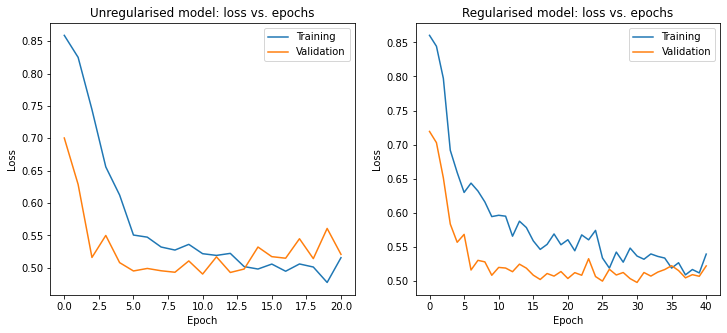

In [37]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()